# EDA

- Understand the 2017 and 2018 energy datasets
- Understand the household survey dataset
- Identify key columns to be used for further analysis
- Identify key operations to clean and transform the dataset
- Visualise the data

## Setup

In [1]:
# Standard imports
import logging

import dask
import dask.dataframe as dd
import hvplot.dask
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Create a Dask dashboard to visualise and track memory, CPU and GPU usage.
from dask.distributed import Client, LocalCluster

# Only show errors, suppress warnings
dask.config.set({"logging.distributed": "error"})
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit="2GB",
    silence_logs=logging.ERROR,
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39119,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:40061,Total threads: 2
Dashboard: http://127.0.0.1:33453/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:44585,


## Data Exploration

### Extract the data

- Extract the SAVE household survey data
- Extract the SAVE energy consumption data for 2017 and 2018

In [3]:
# Load the survey data
survey_df = pd.read_csv(
    "../data/csv/household_survey/save_household_survey_data_v0-3.csv"
)

# Energy data
# Create a Dask dataframe that reads all of the 2017 energy data CSV files
df_2017 = dd.read_csv(
    "/home/alan/projects/dissertation/data/csv/energy_consumption/2017/*.csv"
)

# Create a Dask dataframe that reads all of the 2018 energy data CSV files
df_2018 = dd.read_csv(
    "/home/alan/projects/dissertation/data/csv/energy_consumption/2018/*.csv"
)

In [4]:
# Understand each dataset

# Survey dataset
print("Survey data information\n")
print(survey_df.info())
print()
print(survey_df.columns)
print()
print(survey_df.head())
print()
print(
    f"Number of rows with missing ID: {survey_df[survey_df['BMG_ID'].isna()].count()}"
)
print()
print(f"Number of households: {len(survey_df['BMG_ID'].unique())}")


# 2017 energy dataset
print("\nEnergy data information: 2017\n")
print(df_2017.info())
print()
print(df_2017.head())
print()
print(
    f"Number of rows with missing data: {df_2017[df_2017['bmg_id'].isna()].count().compute()}"
)
print(f"Number of households: {df_2017['bmg_id'].unique().count().compute()}")

# 2018 energy dataset
print("\nEnergy data information: 2018\n")
print(df_2018.info())
print()
print(df_2018.head())
print()
print(
    f"Number of rows with missing data: {df_2018[df_2018['bmg_id'].isna()].count().compute()}"
)
print(f"Number of households: {df_2018['bmg_id'].unique().count().compute()}")

Survey data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4728 entries, 0 to 4727
Columns: 301 entries, BMG_ID to decile
dtypes: float64(160), int64(138), object(3)
memory usage: 10.9+ MB
None

Index(['BMG_ID', 'Intervention', 'surveyMode', 'InterviewDate',
       'wgtRakeAgeTenure', 'Q2', 'Q2B', 'Q2C', 'Q2D', 'Q2DWORK',
       ...
       'Q8_25', 'Q8_26', 'Q8_27', 'la_Name', 'gor_Name', 'UrbanRural_Name',
       'UrbanRural_SubName', 'quartile', 'quintile', 'decile'],
      dtype='object', length=301)

      BMG_ID  Intervention   surveyMode InterviewDate  wgtRakeAgeTenure   Q2  \
0  956600023             2  CAPI Survey    2018-08-23          0.733782  1.0   
1  956600025             3  CAPI Survey    2018-09-06          0.975945  2.0   
2  956600047             2  CAPI Survey    2018-09-29          0.699298  2.0   
3  956600048             1  CAPI Survey    2018-09-29          1.620269  2.0   
4  956600076             1  CAPI Survey    2018-09-29          0.699298  3

### Initial Inferences

**Based on the above dataset information, a few key transforms are required.**
- Change the timestamps to datetime (64) (not required for the survey data, as we will not be using these columns)
- Change the energy readings to float64

**Inferences from the above dataset information**
- Energy data is recorded in its whole value; conversion is required to calculate the energy consumption.
- Energy information is in 15-minute intervals.
- The ID field needs to be mapped from the energy to the survey dataset
    - The last 9 characters from the energy dataset = ID in the survey dataset

### Cleaning and Isolating Student Households

- Convert the timestamps to datetime

In [5]:
# Data cleaning
# Set datetime datatype
df_2017["received_timestamp"] = dd.to_datetime(
    df_2017["received_timestamp"], unit="s", origin="unix"
)
df_2017["recorded_timestamp"] = dd.to_datetime(
    df_2017["recorded_timestamp"], unit="s", origin="unix"
)
df_2018["received_timestamp"] = dd.to_datetime(
    df_2018["received_timestamp"], unit="s", origin="unix"
)
df_2018["recorded_timestamp"] = dd.to_datetime(
    df_2018["recorded_timestamp"], unit="s", origin="unix"
)

# Verify the datatype values
print(df_2017.info())
print(df_2018.info())

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 4 entries, bmg_id to energy
dtypes: datetime64[ns](2), float64(1), string(1)None
<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 4 entries, bmg_id to energy
dtypes: datetime64[ns](2), float64(1), string(1)None


### Understanding the Energy Consumption

In [6]:
# Understand the distribution of energy consumption across all households
# 2017
df_2017.hvplot.hist(
    y="energy",
    xlabel="Energy (Wh)",
    ylabel="Density",
    bins=50,
    title="Energy Distribution 2017",
)

:Histogram   [energy]   (Count)

In [7]:
df_2018.hvplot.hist(
    y="energy",
    xlabel="Energy (Wh)",
    ylabel="Density",
    bins=50,
    title="Energy Distribution 2018",
)

:Histogram   [energy]   (Count)

In [8]:
# Understand the difference between the received_timestamp and recorded_timestamp
# Assume a single sample and understand the distribution of days
sample = df_2017[df_2017["bmg_id"] == "A1956619986"]

# Find the avg difference between the received_timestamp and recorded_timestamp
sample["delay"] = (
    sample["received_timestamp"] - sample["recorded_timestamp"]
).dt.total_seconds()
# Plot delay over recorded time
sample.hvplot(
    x="recorded_timestamp",
    y="delay",
    kind="line",
    title="Transmission Delay Over Time",
)

:Curve   [recorded_timestamp]   (delay)

In [9]:
sample.hvplot.hist(
    y="delay", bins=50, title="Distribution of Transmission Delay"
)

:Histogram   [delay]   (Count)

In [10]:
sample.hvplot.scatter(
    x="recorded_timestamp",
    y="received_timestamp",
    title="Recorded vs. Received Timestamp",
)

:Scatter   [recorded_timestamp]   (received_timestamp)

Inferences: Based on the above distributions of recorded vs. received timestamps, it is evident that there is a significant difference between a meter reading (smart meter or otherwise), represented as the recorded timestamp, and the logged reading time, represented as the received timestamp. 

Per the SAVE documents, this lag is due to network and system delays in capturing the energy meter readings. This makes the recorded timestamp a more reliable measure (timestamp per the meter) as it has no external dependencies (SAVE docs have this reversed).

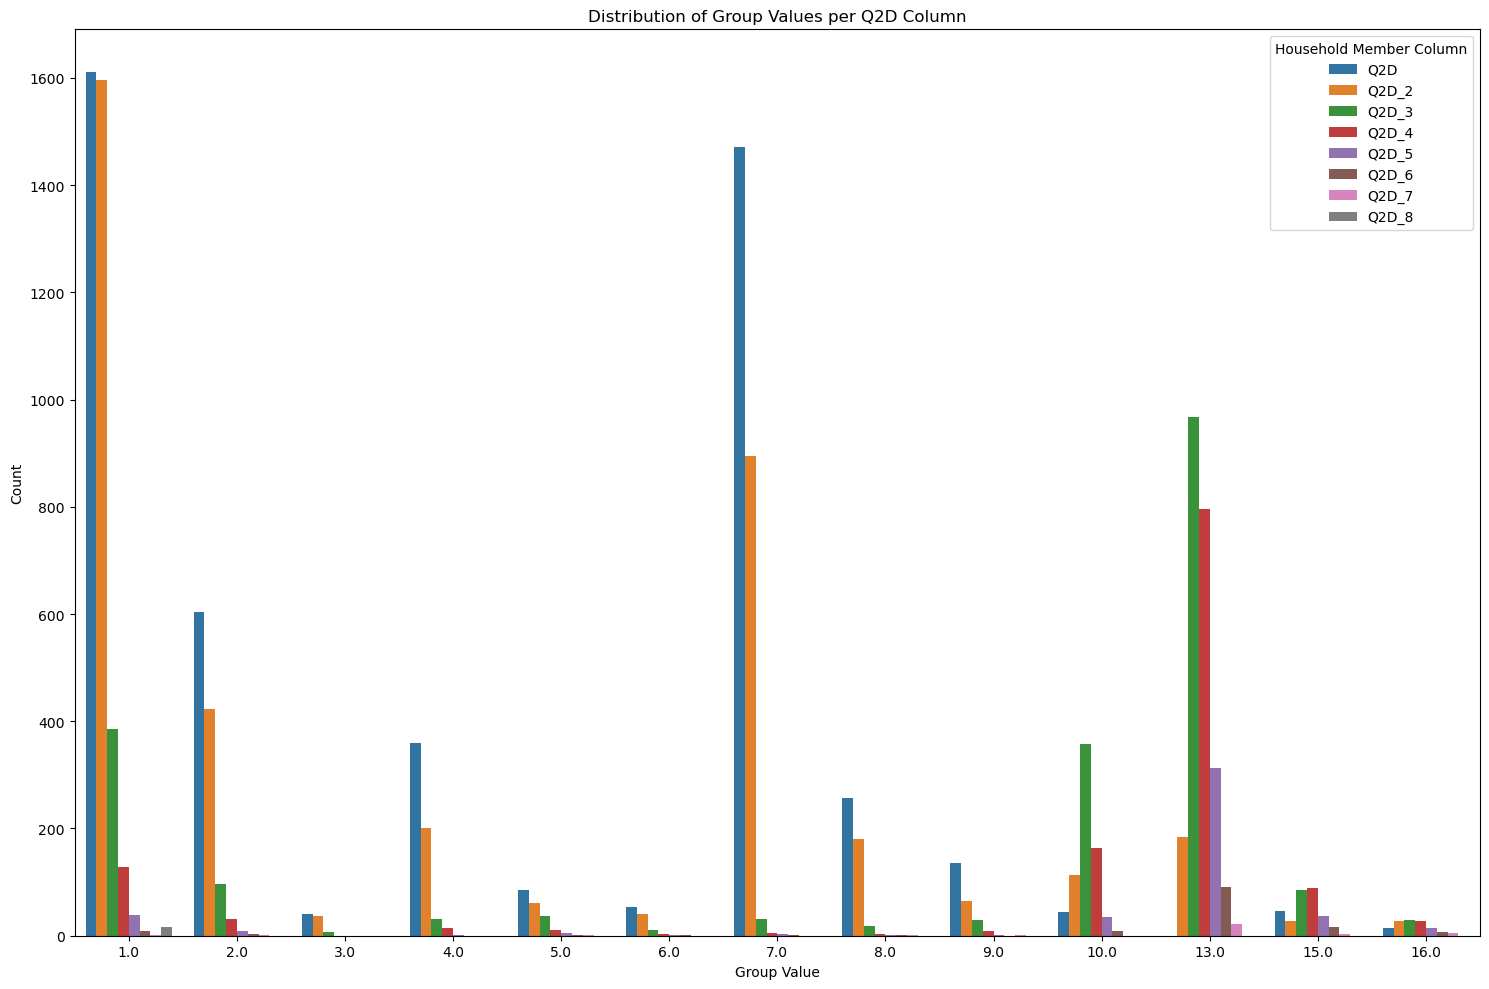

In [11]:
# List all Q2D columns
q2d_columns = [f"Q2D_{i}" if i > 1 else "Q2D" for i in range(1, 9)]

# Melt the DataFrame into long format
melted = survey_df[q2d_columns].melt(var_name="Q2D_Column", value_name="Group")

# Drop NaN values (optional, since you only want actual responses)
melted = melted.dropna()

# Plot the count of each group value for each Q2D column
plt.figure(figsize=(15, 10))
sns.countplot(
    data=melted[melted["Group"] != 0],
    x="Group",
    hue="Q2D_Column",
    palette="tab10",
)

plt.title("Distribution of Group Values per Q2D Column")
plt.xlabel("Group Value")
plt.ylabel("Count")
plt.legend(title="Household Member Column")
plt.tight_layout()
plt.show()

This study is specifically interested in student households. We want to analyse the relationship between student households
and various household factors. To do this, we first isolate the student households. 

Per the SAVE data dictionaries, each resident answers specific questions, occupation is represented by Q2D_*, where * is in the range [1, 8], representing each resident. If this value is 10 or 11, then this represents a student. Furthermore, per the SAVE documentation, part-time roles and their equivalents have a higher priority to student. This could lead to the distribution of students being skewed. 

Inference: Unfortunately, there aren't any households that consist only of students for us to analyse. Therefore, we are forced to study households that have at least one student. 

We, therefore, filter the dataset to identify only these households.

From the above histogram plot, we can see that most households are of sizes 1 or 2. With a majority of the households have the first resident as a full time employee and the second as a full time employee as well, or both being retired.

From the above distribution, we have the following options:

- Select households that have at least 1 student -> 565
- Select households that have at least 1 student and no full-time employees -> 157
- Select households where the majority members are students-> 13

We are continuing under the first assumption. However, if there is a change to the assumption, the condition below must be updated. All other aspects of the analysis remain the same.

#### Assumption 1

Number of households: 565


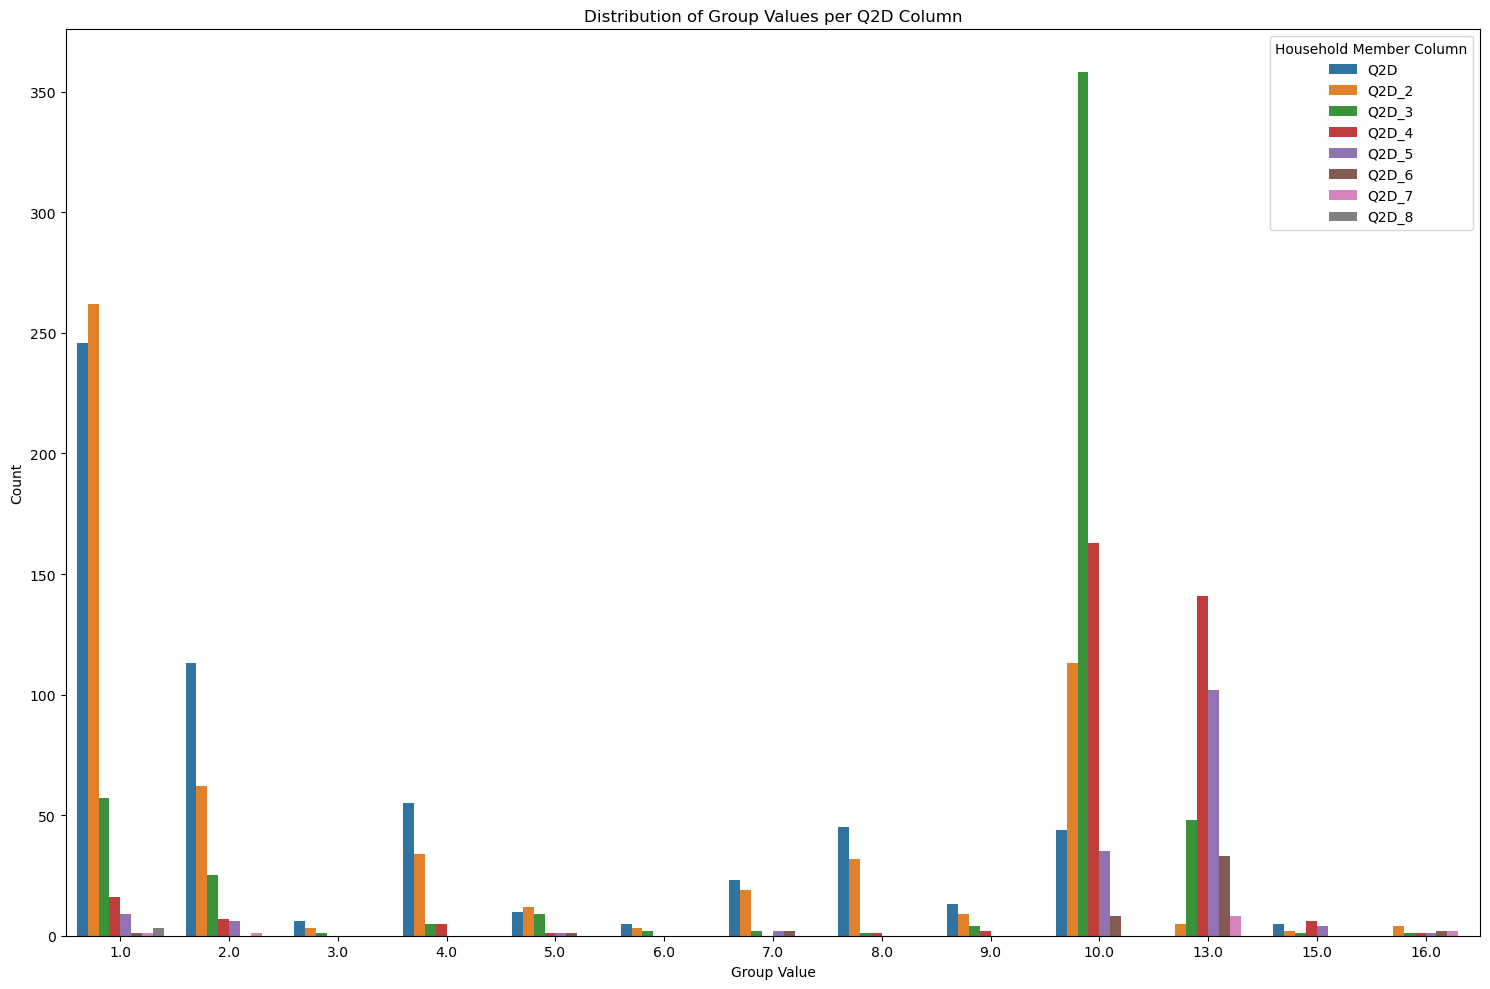

In [12]:
# Assumption 1: At least 1 student in the household
# List all Q2D columns representing household members
q2d_columns = [f"Q2D_{i}" if i > 1 else "Q2D" for i in range(1, 9)]

# Filter households where any existing Q2D values are in [10, 11, 12]
condition = survey_df[q2d_columns].apply(
    lambda row: row.dropna().isin([10, 11]).any(),
    axis=1,
)

# Extract BMG_IDs from those households
BMG_ID_student = survey_df.loc[condition, "BMG_ID"]
print(f"Number of households: {len(BMG_ID_student)}")

# Melt the DataFrame into long format
melted = survey_df[survey_df["BMG_ID"].isin(BMG_ID_student)][q2d_columns].melt(
    var_name="Q2D_Column", value_name="Group"
)

# Drop NaN values
melted = melted.dropna()

# Plot the count of each group value for each Q2D column
plt.figure(figsize=(15, 10))
sns.countplot(
    data=melted[melted["Group"] != 0],
    x="Group",
    hue="Q2D_Column",
    palette="tab10",
)
plt.title("Distribution of Group Values per Q2D Column")
plt.xlabel("Group Value")
plt.ylabel("Count")
plt.legend(title="Household Member Column")
plt.tight_layout()
plt.show()

#### Assumption 2

157


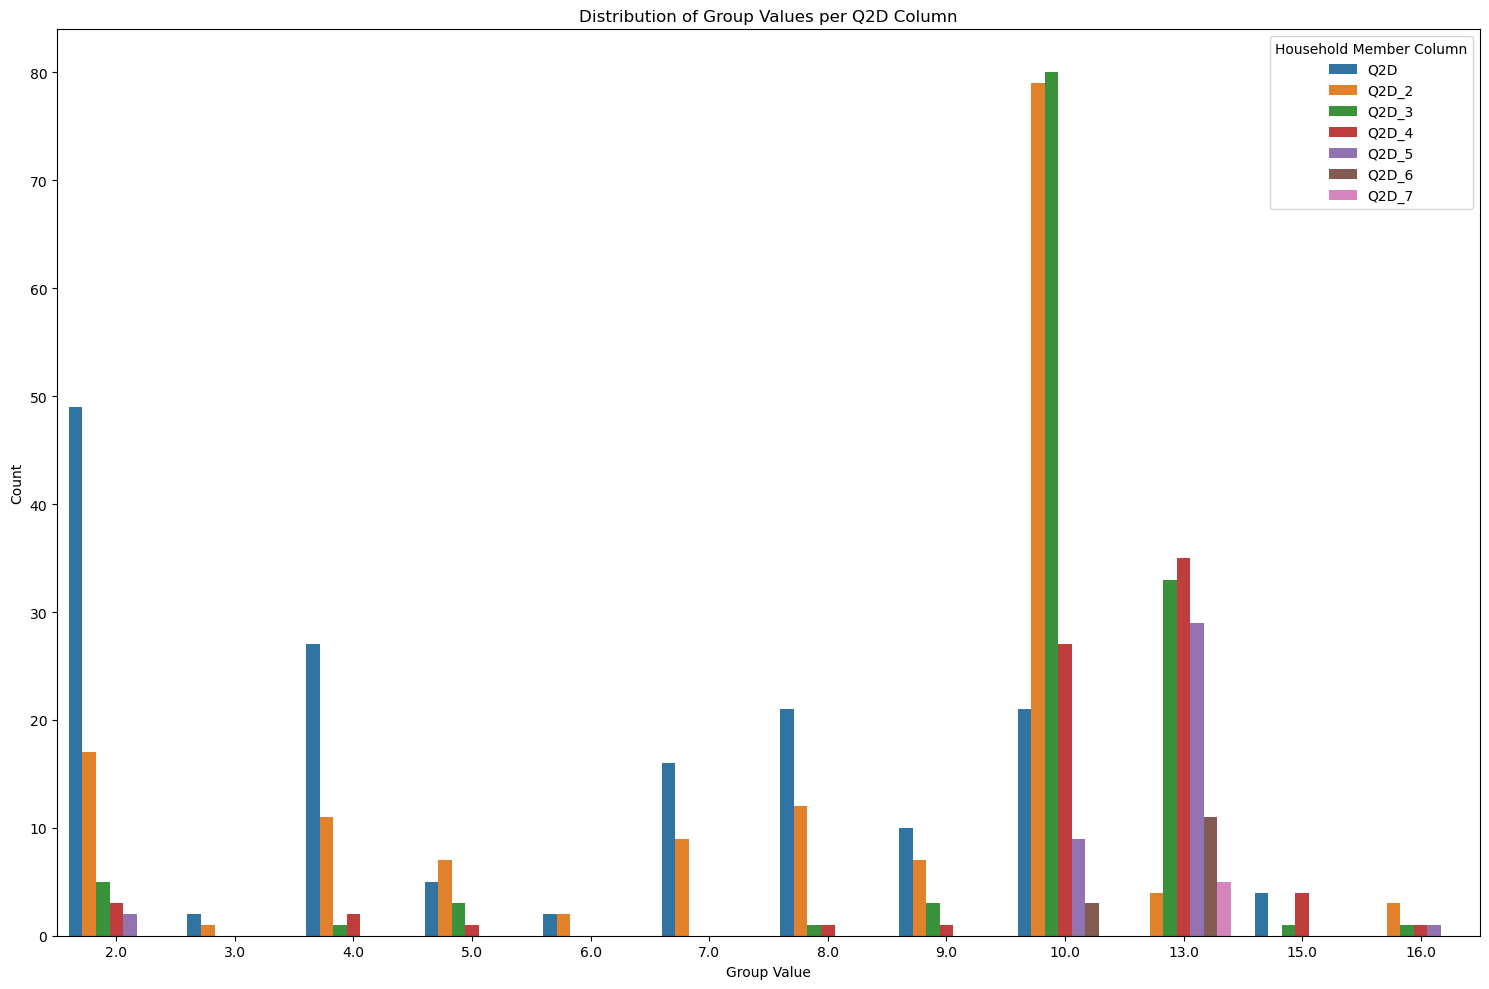

In [13]:
# Assumption 2: Student and no FTE
# List all Q2D columns representing household members
q2d_columns = [f"Q2D_{i}" if i > 1 else "Q2D" for i in range(1, 9)]

# Filter households where any existing Q2D values are in [10, 11, 12]
condition = survey_df[q2d_columns].apply(
    lambda row: row.dropna().isin([10, 11]).any()
    and not row.dropna().isin([1]).any(),
    axis=1,
)

# Extract BMG_IDs from those households
BMG_ID_student = survey_df.loc[condition, "BMG_ID"]
print(len(BMG_ID_student))

student_survey_df = survey_df[survey_df["BMG_ID"].isin(BMG_ID_student)].copy()
# Melt the DataFrame into long format
melted = student_survey_df[q2d_columns].melt(
    var_name="Q2D_Column", value_name="Group"
)

# Drop NaN values (optional, since you only want actual responses)
melted = melted.dropna()

# Plot the count of each group value for each Q2D column
plt.figure(figsize=(15, 10))
sns.countplot(
    data=melted[melted["Group"] != 0],
    x="Group",
    hue="Q2D_Column",
    palette="tab10",
)

plt.title("Distribution of Group Values per Q2D Column")
plt.xlabel("Group Value")
plt.ylabel("Count")
plt.legend(title="Household Member Column")
plt.tight_layout()
plt.show()

#### Assumption 3

       Q2D  Q2D_2  Q2D_3  Q2D_4  Q2D_5  Q2D_6  Q2D_7  Q2D_8
684   10.0     10     10     10      0      0      0      0
690   10.0     10     10     10      0      0      0      0
787    2.0     10     10     10     10     10      0      0
790   10.0     10     10     10     10     10      0      0
978    2.0     10     10     10     10      0      0      0
979    2.0     10     10     10     10      0      0      0
1007   1.0     10     10     13     10     10      0      0
1097  10.0     10     10     10     10      0      0      0
1310  10.0     10     10     10      0      0      0      0
1373  10.0     10     10     10      0      0      0      0
1415  10.0     10     10     10     10      0      0      0
3376   1.0      1     10     10     10     10      0      0
4268   1.0      1     10     10     10     10      0      0


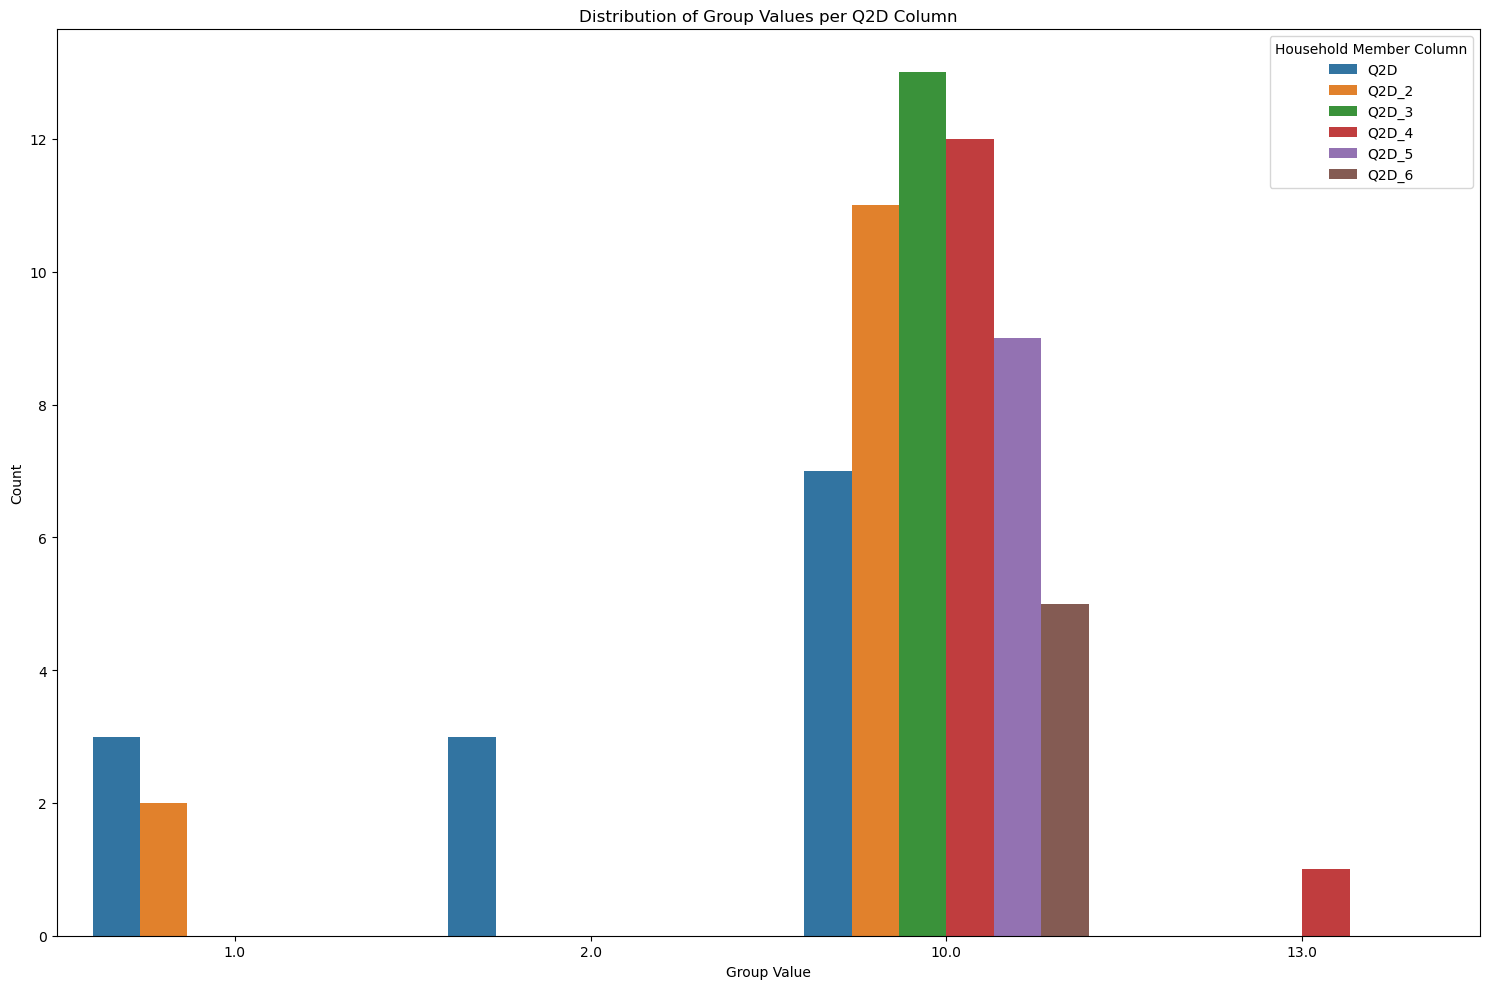

In [14]:
# Assumption 3: The Majority of residents are students
# List all Q2D columns representing household members
q2d_columns = [f"Q2D_{i}" if i > 1 else "Q2D" for i in range(1, 9)]


# Define the group filter function
def group_ratio(row):
    values = row.dropna()
    if values.isin([10, 11]).any():
        total_members = len(values)
        target_group_members = values.isin([10, 11]).sum()
        ratio = target_group_members / total_members
        return ratio
    else:
        return None  # Household does not meet criteria


# Apply the function across rows to compute the ratio
survey_df["target_group_ratio"] = survey_df[q2d_columns].apply(
    group_ratio, axis=1
)

# Drop NaNs to keep only rows where the condition was satisfied
filtered_ratios = survey_df.dropna(subset=["target_group_ratio"])

# Display or analyse results
print(
    filtered_ratios[filtered_ratios["target_group_ratio"] >= 0.5][q2d_columns]
)

student_survey_df = survey_df[survey_df["BMG_ID"].isin(BMG_ID_student)].copy()
# Melt the DataFrame into long format
melted = filtered_ratios[filtered_ratios["target_group_ratio"] >= 0.5][
    q2d_columns
].melt(var_name="Q2D_Column", value_name="Group")

# Drop NaN values (optional, since you only want actual responses)
melted = melted.dropna()

# Plot the count of each group value for each Q2D column
plt.figure(figsize=(15, 10))
sns.countplot(
    data=melted[melted["Group"] != 0],
    x="Group",
    hue="Q2D_Column",
    palette="tab10",
)

plt.title("Distribution of Group Values per Q2D Column")
plt.xlabel("Group Value")
plt.ylabel("Count")
plt.legend(title="Household Member Column")
plt.tight_layout()
plt.show()

In [15]:
client.shutdown()